Mounting the drive the unzipping the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir data
!unzip "/content/drive/MyDrive/RetiHack/ParkinsonSpeech/archive.zip"

mkdir: cannot create directory ‘data’: File exists
Archive:  /content/drive/MyDrive/RetiHack/ParkinsonSpeech/archive.zip
  inflating: pd_speech_features.csv  


Importing modules

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn import datasets, metrics
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import FastICA
from sklearn.metrics import accuracy_score, log_loss
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

Data is avaiable in [kaggle](https://www.kaggle.com/dipayanbiswas/parkinsons-disease-speech-signal-features?select=pd_speech_features.csv) the data is on Audio Features related to Parkinson's disease. Both AD and Parkinson's can have similar affects on the motor motion therefore the idea was that maybe we can use this model to score all the audio data collected by the application.

In [8]:
data = pd.read_csv('pd_speech_features.csv') 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [9]:
data.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,...,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,...,0.729330,0.780410,5.22940,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,...,0.269510,-0.005522,0.35054,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0.147370,...,0.366920,-0.492650,0.19164,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.3

In [10]:
data.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,756.00000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,0.000605,0.001159,0.001815,0.067473,0.60642,0.034375,0.041175,0.055366,0.103125,0.961508,0.051131,18.859632,70.828609,76.135371,73.997008,647.174519,1233.852088,2562.425251,3547.259244,213.363237,297.174077,536.821070,506.604856,0.904423,32.295832,4.454840,1.092503,0.215038,0.144832,...,-0.041840,-0.015615,-0.005242,1059.146612,377.357439,328.927860,317.994439,305.036007,172.362746,40.408662,15.064513,12.107316,11.757945,11.871530,9.529080,3.741615,3.332313,3.270290,2.995472,2.710678,2.608229,2.553457,2.432001,2.300006,2.183111,2.176542,2.595250,6.782668,15.766942,21.026054,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,0.000981,0.001677,0.002942,0.042969,0.38257,0.022366,0.027165,0.033939,0.067097,0.064095,0.104579,5.576473,8.858268,6.446451,7.018006,134.957916,169.090402,393.315598,347.864299,306.976045,450.125488,754.341717,658.326606,0.147826,31.140746,7.313057,0.350789,0.132549,0.060065,...,1.431979,1.451535,4.448635,3522.528562,1514.808488,1338.602187,1275.228777,1211.296576,821.740615,239.548628,75.865176,77.370230,74.594974,39.125733,36.349168,4.821202,2.962967,2.049877,1.444227,1.310653,1.229086,1.061068,0.892523,0.868506,0.796446,1.709860,5.979131,31.707014,45.247304,43.716898,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,

Finding stats for **NaN** enteries in the dataset. 

In [11]:
null_values=data.isnull().sum()
null_values=pd.DataFrame(null_values, columns=['null'])
j=1
sum_tot=len(data)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent', ascending=False)

,null,percent
id,0,0.0
tqwt_medianValue_dec_6,0,0.0
tqwt_TKEO_std_dec_33,0,0.0
tqwt_TKEO_std_dec_34,0,0.0
tqwt_TKEO_std_dec_35,0,0.0
...,...,...
det_LT_entropy_log_2_coef,0,0.0
det_LT_entropy_log_3_coef,0,0.0
det_LT_entropy_log_4_coef,0,0.0
det_LT_entropy_log_5_coef,0,0.0


Splitting the dataset into train and test sets. (**80-20 split, not stratified**)

In [12]:
from sklearn.model_selection import train_test_split
y = data.loc[:,'class']
X = data.drop(['class', 'id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

Fitting the Scalars.

In [13]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

Checking for any unbalance.

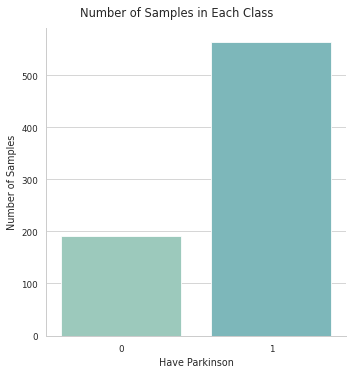

In [14]:
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('GnBu_d')
a = sns.catplot(x='class', data=data, kind='count')
a.fig.suptitle('Number of Samples in Each Class', y=1.03)
a.set(ylabel='Number of Samples', xlabel='Have Parkinson')
plt.show()

There is a significant imbalance in the dataset which we need to accounf for. Using the dummy classifier to classify the data.

In [15]:
from sklearn.dummy import DummyClassifier

# setting up testing and training sets
y = data.loc[:,'class']
X = data.drop(['class', 'id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [1]
Test score:  0.7566137566137566


Using the logistic regression model.

In [18]:
# Modeling the data as is
# Train model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print(f' Accuracy Score of Logistic Regression: {accuracy_score(y_test, lr_pred)}')

 Accuracy Score of Logistic Regression: 0.8201058201058201


Oversampling to balance the dataset to improve the classification accuracy of minority class.

In [19]:
from sklearn.utils import resample

# Separate input features and target
y = data.loc[:,'class']
X = data.drop(['class', 'id'], axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
parkinson = X.loc[X['class'] == 1]
not_parkinson = X.loc[X['class'] == 0]


# upsample minority
fraud_upsampled = resample(not_parkinson,
                          replace=True, # sample with replacement
                          n_samples=len(parkinson), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([parkinson, fraud_upsampled])
y_train_up = upsampled.loc[:,'class']
X_train_up = upsampled.drop(['class'], axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_up = min_max_scaler.fit_transform(X_train_up)
X_test = min_max_scaler.transform(X_test)
upsampled['class'].value_counts()

1    421
0    421
Name: class, dtype: int64

In [20]:
smote = LogisticRegression(solver='liblinear').fit(X_train_up, y_train_up)

smote_pred = smote.predict(X_test)
print("--------------------------------------------------")
print("||==============================================||")
print("|| Oversample Minority Class Accuracy:=> {:.2f} % ||".format(accuracy_score(y_test, smote_pred)*100))
print("||==============================================||")
print("--------------------------------------------------")

--------------------------------------------------
||==============================================||
|| Oversample Minority Class Accuracy:=> 80.42 % ||
||==============================================||
--------------------------------------------------


Using **SMOTE** (Synthetic Minority Over-sampling Technique) to generate artificial samples.

In [21]:
from imblearn.over_sampling import SMOTE
# 
# Separate input features and target
y = data.loc[:,'class']
X = data.drop(['class', 'id'], axis=1)

# setting up testing and trainingsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)


min_max_scaler = preprocessing.MinMaxScaler()
              
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

sm = SMOTE(sampling_strategy='mirity', random_state=27)
# X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# oversampled_train = pd.concat([pd.DataFrame(y_train_smote, columns=['class']), pd.Datrame(X_train_smote)], axis=1)
# oversampled_train['class'].value_counts()
# oversampled_train oversampled_train

In [22]:
# smote = LogisticRegression(solver='liblinear').fit(X_train_smote, y_train_smote)
# 
smote_pred = smote.predict(X_test)

print("--------------------------------------------------")
print("||==============================================||")
print("|| Oversample Minority Class Accuracy:=> {:.2f} % ||".format(accuracy_score(y_test, smote_pred)*100))
print("||==============================================||")
print("--------------------------------------------------")

--------------------------------------------------
||==============================================||
|| Oversample Minority Class Accuracy:=> 79.89 % ||
||==============================================||
--------------------------------------------------


Visualizing thew model's performance 

### Confusion Matrix

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('01')
    plt.xlabel('01')

### ROC-Plot

In [24]:
def plot_roc_curve(y_test, y_pred):
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(8, 6))

    # method I: plt
    plt.title('Receiver Operating Characteristic', fontsize=14)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right', fontsize=11)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.005, 1])
    plt.ylim([0, 1.005])
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.grid(color='r', linestyle='--', linewidth=0.2)
    plt.show()

Final dataset selection for the model using **oversampling balanced dataset**.

In [25]:
X_train = X_train_up
y_train = y_train_up

In [26]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

Undoing the oversampling and refitting with no emphasis on class-imabalnce.

In [27]:
y = data.loc[:,'class']
X = data.drop(['class', 'id'], axis=1)

from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object with a variance with a threshold of 0.5
# thresholder = VarianceThreshold(threshold=.5)

# # Conduct variance thresholding
# X_high_variance = thresholder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

X = min_max_scaler.transform(X)

plt.style.use('default')
from sklearn.metrics import accuracy_score

### Using different Classifiers to classify the disease using ML features.

1. Gaussian Naive Bias Classifier.

--------------------------------------------------------
||====================================================||
|| Train Accuracy GaussianNB Model :=> 75.66%  ||
||====================================================||
--------------------------------------------------------
||====================================================||
|| Test Accuracy GaussianNB Model :=> 70.39%  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Binary Cross Entropy - GaussianNB Model :=> 10.23  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Cross Entropy Accuracy :=> 75.39% +- 2.73%  ||
||===================================================

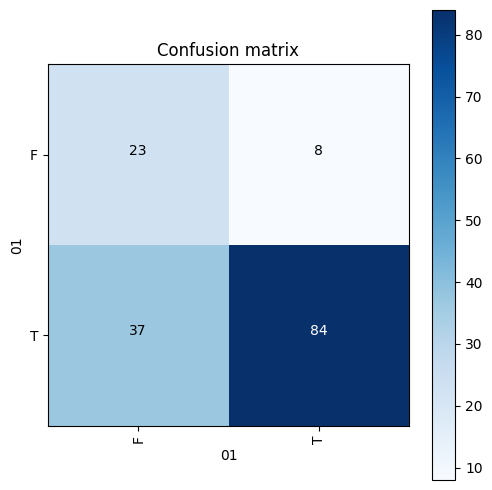

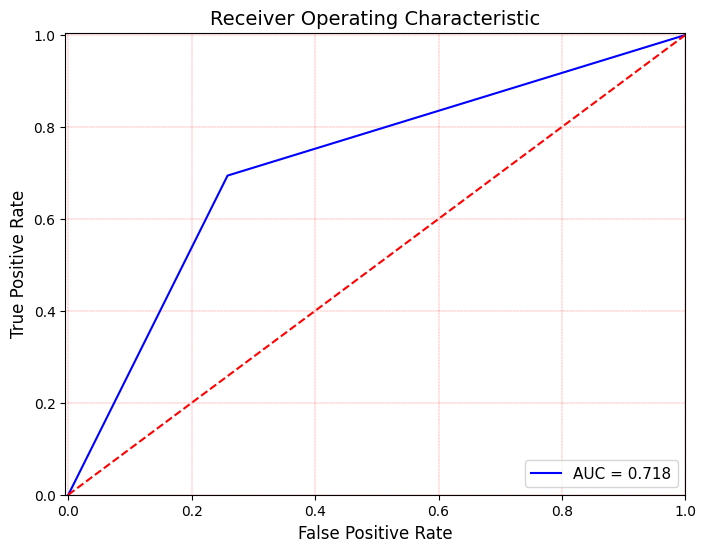

In [28]:
def my_GaussianNB(X_train, y_train, X_test, y_test, X, y):
    clf = GaussianNB()

    # fitting the classifier
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Train Accuracy GaussianNB Model :=> %.2f%%" % (accuracy_score(y_train, y_pred_train)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Test Accuracy GaussianNB Model :=> %.2f%%" % (accuracy_score(y_test, y_pred)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Binary Cross Entropy - GaussianNB Model :=> {:.2f}".format(log_loss(y_test, y_pred)), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Cross Entropy Accuracy :=> %.2f%% +- %.2f%%" %(np.mean(acc)*100,np.std(acc)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    confusion_mtx = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names="FT"))
    plot_confusion_matrix(confusion_mtx, "FT")

    plot_roc_curve(y_test, y_pred)

my_GaussianNB(X_train, y_train, X_test, y_test, X, y)

2. Minimum Distance Classifier

--------------------------------------------------------
||====================================================||
|| Train Accuracy Minimum Distance Model :=> 72.35%  ||
||====================================================||
--------------------------------------------------------
||====================================================||
|| Test Accuracy Minimum Distance Model :=> 73.03%  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Binary Cross Entropy - Minimum Distance Model :=> 9.32  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Cross Entropy Accuracy :=> 71.04% +- 3.63%  ||
||==================================

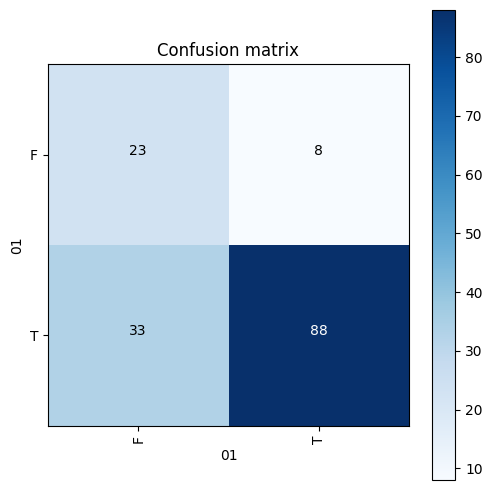

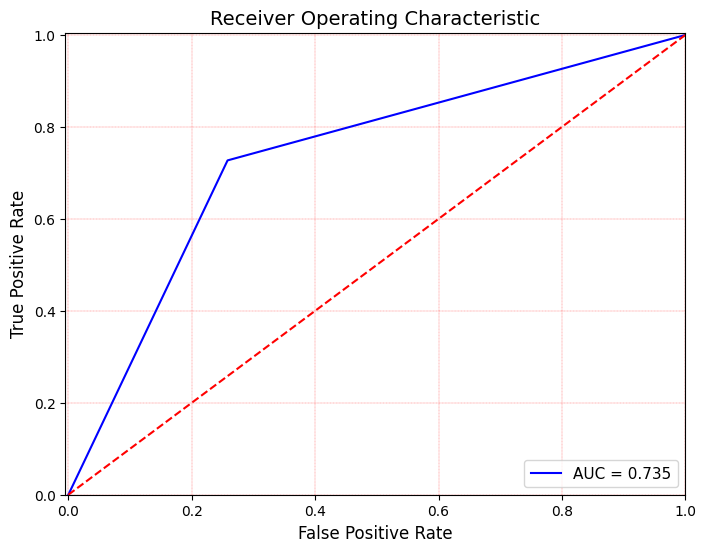

In [29]:
from sklearn.neighbors import NearestCentroid

def my_NearestCentroid(X_train, y_train, X_test, y_test, X, y):
    clf = NearestCentroid(metric='euclidean')
    # fitting the classifier
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Train Accuracy Minimum Distance Model :=> %.2f%%" % (accuracy_score(y_train, y_pred_train)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Test Accuracy Minimum Distance Model :=> %.2f%%" % (accuracy_score(y_test, y_pred)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Binary Cross Entropy - Minimum Distance Model :=> {:.2f}".format(log_loss(y_test, y_pred)), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Cross Entropy Accuracy :=> %.2f%% +- %.2f%%" %(np.mean(acc)*100,np.std(acc)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    confusion_mtx = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names="FT"))
    plot_confusion_matrix(confusion_mtx, "FT")

    plot_roc_curve(y_test, y_pred)

my_NearestCentroid(X_train, y_train, X_test, y_test, X, y)

3. Logistic Regression Classifier

--------------------------------------------------------
||====================================================||
|| Train Accuracy LogisticRegression Model :=> 93.38%  ||
||====================================================||
--------------------------------------------------------
||====================================================||
|| Test Accuracy LogisticRegression Model :=> 90.13%  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Binary Cross Entropy - LogisticRegression Model :=> 3.41  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Cross Entropy Accuracy :=> 82.67% +- 4.47%  ||
||============================

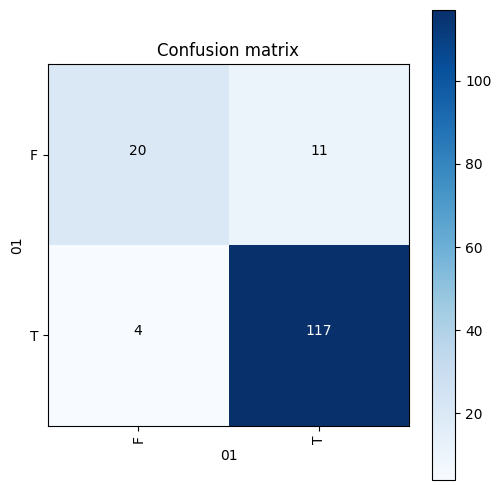

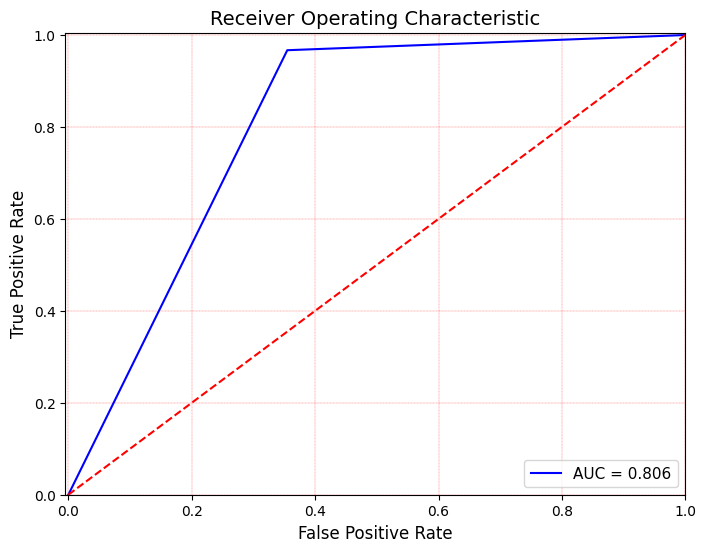

In [30]:
from sklearn.linear_model import LogisticRegression

def my_LogisticRegression(X_train, y_train, X_test, y_test, X, y):
    clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
    # fitting the classifier
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Train Accuracy LogisticRegression Model :=> %.2f%%" % (accuracy_score(y_train, y_pred_train)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Test Accuracy LogisticRegression Model :=> %.2f%%" % (accuracy_score(y_test, y_pred)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Binary Cross Entropy - LogisticRegression Model :=> {:.2f}".format(log_loss(y_test, y_pred)), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Cross Entropy Accuracy :=> %.2f%% +- %.2f%%" %(np.mean(acc)*100,np.std(acc)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    confusion_mtx = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names="FT"))
    plot_confusion_matrix(confusion_mtx, "FT")

    plot_roc_curve(y_test, y_pred)


my_LogisticRegression(X_train, y_train, X_test, y_test, X, y)

4. kNN Classifier

--------------------------------------------------------
||====================================================||
|| Train Accuracy KNN Model :=> 100.00%  ||
||====================================================||
--------------------------------------------------------
||====================================================||
|| Test Accuracy KNN Model :=> 95.39%  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Binary Cross Entropy - KNN Model :=> 1.59  ||
||====================================================||
--------------------------------------------------------
--------------------------------------------------------
||====================================================||
|| Cross Entropy Accuracy :=> 80.54% +- 3.85%  ||
||====================================================||
-----------------

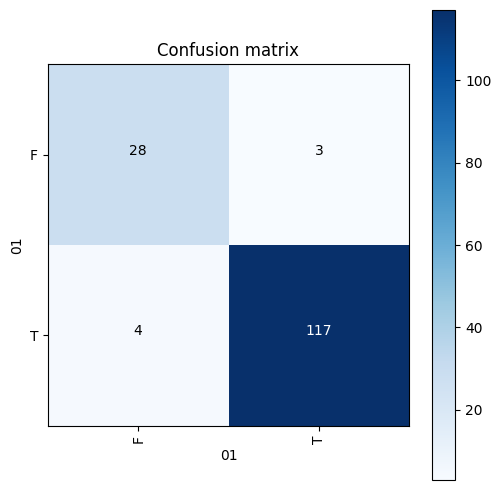

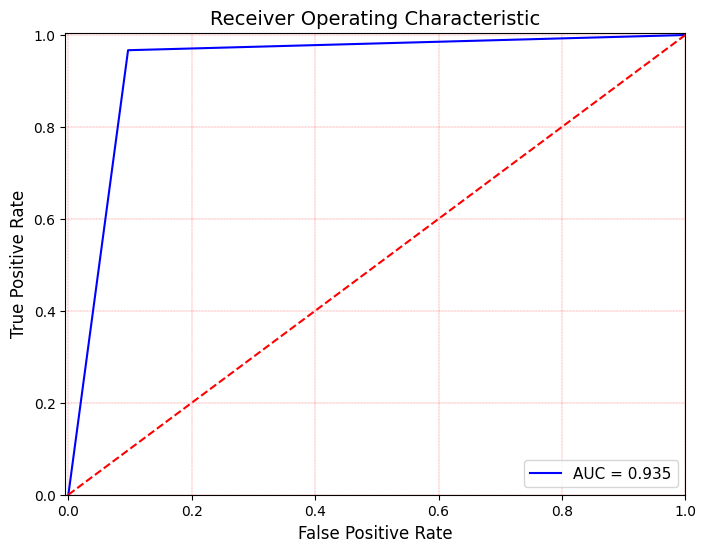

In [31]:
from sklearn.neighbors import KNeighborsClassifier

def my_KNN(X_train, y_train, X_test, y_test, X, y):
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Train Accuracy KNN Model :=> %.2f%%" % (accuracy_score(y_train, y_pred_train)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Test Accuracy KNN Model :=> %.2f%%" % (accuracy_score(y_test, y_pred)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Binary Cross Entropy - KNN Model :=> {:.2f}".format(log_loss(y_test, y_pred)), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    acc = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Cross Entropy Accuracy :=> %.2f%% +- %.2f%%" %(np.mean(acc)*100,np.std(acc)*100), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    confusion_mtx = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names="FT"))
    plot_confusion_matrix(confusion_mtx, "FT")

    plot_roc_curve(y_test, y_pred)

my_KNN(X_train, y_train, X_test, y_test, X, y)

5. MLP Classifier

              precision    recall  f1-score   support

           0       0.67      0.58      0.62        31
           1       0.90      0.93      0.91       121

    accuracy                           0.86       152
   macro avg       0.78      0.75      0.77       152
weighted avg       0.85      0.86      0.85       152

-------------------------------------------------------------------------------------------------------------
||=========================================================================================================||
|| Train Accuracy [Optimizer:adam - AF:relu - Max Iter:30000 - Early Stop:True - Hidden Layer Size:300]:=> 85.60 % ||
||=========================================================================================================||
-------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------
||===

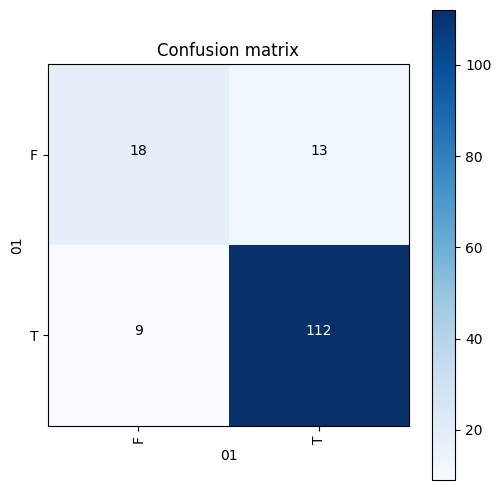

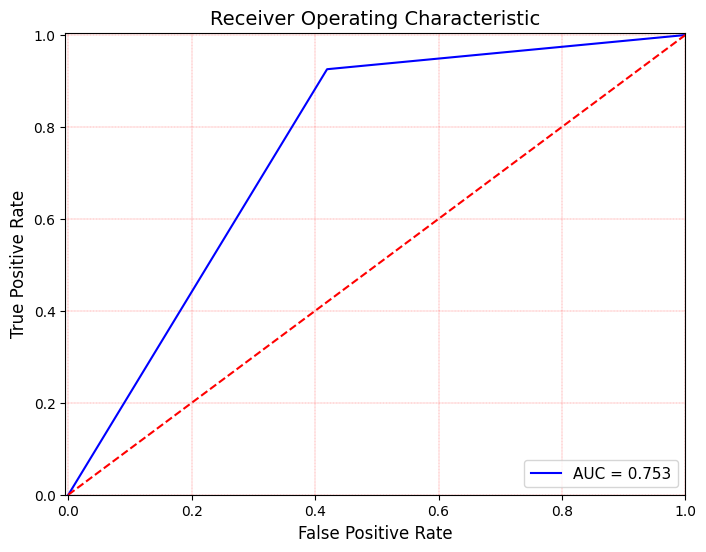

In [34]:
def my_MLP(X_train, y_train, X_test, y_test, X, y):
    hidden_layer_size=300
    max_iteration=30000
    activation_function='relu'
    optimizer='adam'
    early_stopping = True
    ###################################
    mlp_adam = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, 30), max_iter=max_iteration, 
                            activation=activation_function, solver=optimizer, 
                            learning_rate='adaptive', early_stopping=early_stopping)
    mlp_adam.fit(X_train, y_train)

    y_pred = mlp_adam.predict(X_test)

    print("======================================================")
    print(classification_report(y_test, y_pred))
    print("======================================================")

    y_pred_train = mlp_adam.predict(X_train)
    print("-------------------------------------------------------------------------------------------------------------")
    print("||=========================================================================================================||")
    print("|| Train Accuracy [Optimizer:{} - AF:{} - Max Iter:{} - Early Stop:{} - Hidden Layer Size:{}]:=> {:.2f} %".format(optimizer, 
                                                                                activation_function, 
                                                                                max_iteration,
                                                                                early_stopping,
                                                                                hidden_layer_size,
                                                                                accuracy_score(y_train, y_pred_train)*100
                                                                                )
    , "||")
    print("||=========================================================================================================||")
    print("-------------------------------------------------------------------------------------------------------------")

    print("-------------------------------------------------------------------------------------------------------------")
    print("||=========================================================================================================||")
    print("|| Test Accuracy [Optimizer:{} - AF:{} - Max Iter:{} - Early Stop:{} - Hidden Layer Size:{}]:=> {:.2f} %".format(optimizer, 
                                                                                activation_function, 
                                                                                max_iteration,
                                                                                early_stopping,
                                                                                hidden_layer_size,
                                                                                accuracy_score(y_test, y_pred)*100
                                                                                )
    , "||")
    print("||=========================================================================================================||")
    print("-------------------------------------------------------------------------------------------------------------")

    print("--------------------------------------------------------")
    print("||====================================================||")
    print("|| Binary Cross Entropy - MLP Model :=> {:.2f}".format(log_loss(y_test, y_pred)), " ||")
    print("||====================================================||")
    print("--------------------------------------------------------")

    # acc = cross_val_score(mlp_adam, X, y, cv=5, scoring='accuracy')
    # print("--------------------------------------------------------")
    # print("||====================================================||")
    # print("|| Cross Entropy Accuracy :=> %.2f%% +- %.2f%%" %(np.mean(acc)*100,np.std(acc)*100), " ||")
    # print("||====================================================||")
    # print("--------------------------------------------------------")

    confusion_mtx = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names="FT"))
    plot_confusion_matrix(confusion_mtx, "FT")

    # method I: plt
    plot_roc_curve(y_test, y_pred)

my_MLP(X_train, y_train, X_test, y_test, X, y)

6. SVM Classifier

||============================================================================||
||----------------------------------------------------------------------------||
|| Accuracy of SVM with linear Kernel, One-vs-Rest:=> 84.21 %                ||
||----------------------------------------------------------------------------||
|| Accuracy of SVM with linear Kernel, One-vs-One:=> 84.21 %                 ||
|| ---------------------------------------------------------------------------||
|| Accuracy of SVM with RBF Kernel, One-vs-Rest:=> 78.95 %                   ||
||----------------------------------------------------------------------------||
|| Accuracy of SVM with polynomial (degree 3) Kernel, One-vs-Rest:=> 87.50 % ||
||============================================================================||
||----------------------------------------------------------------------------||


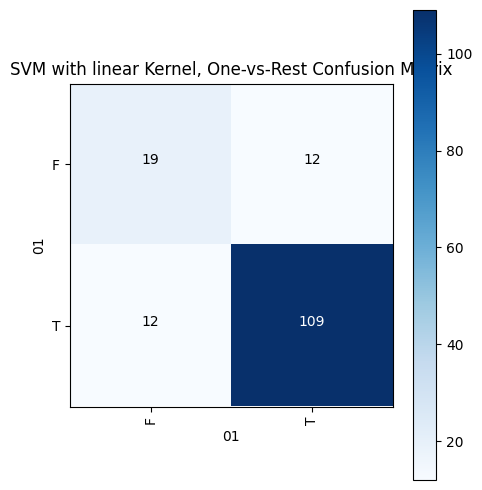

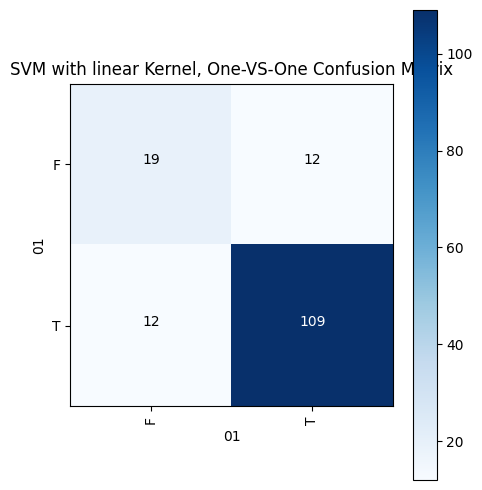

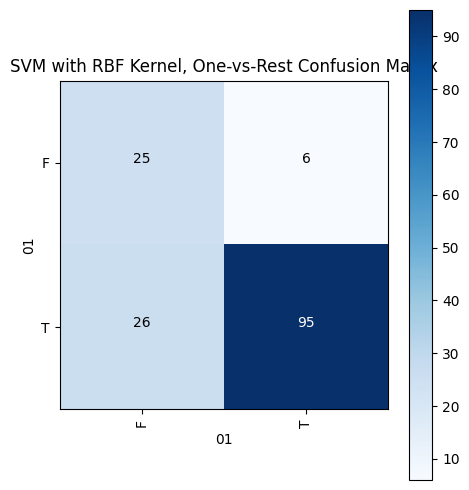

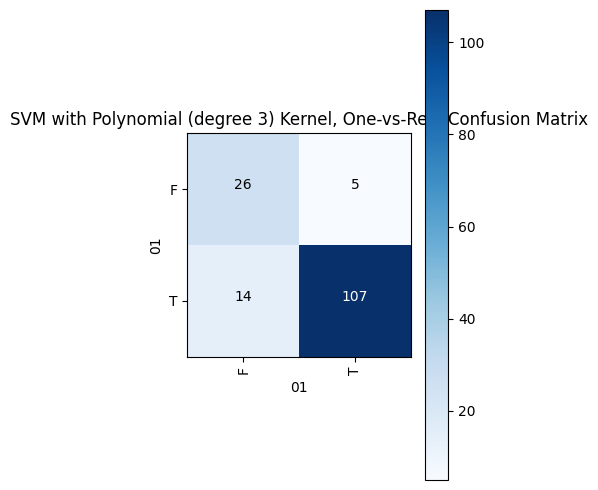

In [33]:
from sklearn import svm

def my_SVM(X_train, y_train, X_test, y_test, X, y):
    X = X_train
    y = y_train

    # class_weight=None
    class_weight='balanced'

    models = (svm.SVC(kernel='linear', decision_function_shape='ovr', class_weight=class_weight),
            svm.SVC(kernel='linear', decision_function_shape='ovo', class_weight=class_weight),
            svm.SVC(kernel='rbf',class_weight=class_weight, decision_function_shape='ovr'),
            svm.SVC(kernel='poly',class_weight=class_weight, degree=3, decision_function_shape='ovr')
            )
    models_fit = (clf.fit(X, y) for clf in models)

    # title for the plots
    titles = ('SVM with linear Kernel, One-vs-Rest',
            'SVM with linear Kernel, One-VS-One',
            'SVM with RBF Kernel, One-vs-Rest',
            'SVM with Polynomial (degree 3) Kernel, One-vs-Rest')



    scores = []
    for clf, title in zip(models_fit, titles):
        scores.append(clf.score(X_test, y_test))


    print("||============================================================================||")
    print("||----------------------------------------------------------------------------||")
    print('|| Accuracy of SVM with linear Kernel, One-vs-Rest:=> {:.2f} %'.format(scores[0]*100), "               ||")
    print("||----------------------------------------------------------------------------||")
    print('|| Accuracy of SVM with linear Kernel, One-vs-One:=> {:.2f} %'.format(scores[1]*100), "                ||")
    print("|| ---------------------------------------------------------------------------||")
    print('|| Accuracy of SVM with RBF Kernel, One-vs-Rest:=> {:.2f} %'.format(scores[2]*100), "                  ||")
    print("||----------------------------------------------------------------------------||")
    print('|| Accuracy of SVM with polynomial (degree 3) Kernel, One-vs-Rest:=> {:.2f} %'.format(scores[3]*100), "||")
    print("||============================================================================||")
    print("||----------------------------------------------------------------------------||")

    models_fit_mat = (clf.fit(X, y) for clf in models)

    plt.style.use('default')
    for title, clf in zip(titles, models_fit_mat):
        y_pred = clf.predict(X_test)
        confusion_mtx = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(confusion_mtx, "FT", title=title+" Confusion Matrix")

my_SVM(X_train, y_train, X_test, y_test, X, y)

We change this model to be a regression model trying to predict 0-1 but with a regression based approach which we can then use to score the audio data from the application to give that data a score which will aggregate to the final MMSE score. ⚾